In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
!pip install scikeras > /dev/null

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from scikeras.wrappers import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from PIL import Image
import gdown
from IPython import display

!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image-2.jpg"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/sliding.gif.png"

# Show sliding windows
def show_sliding_window():
  return display.Image(filename="sliding.gif.png")

# Construct vehicle dataset
label_car = 1
label_truck = 9

# Load data
def load_cifar10():
  (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)

  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)

  return new_data, new_labels

def load_vehicle_dataset():
  (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = load_cifar10()
  X_train, y_train = construct_vehicle_dataset(X_train_cifar, y_train_cifar, 5000)
  X_test, y_test = construct_vehicle_dataset(X_test_cifar, y_test_cifar, 1000)
  return (X_train, y_train), (X_test, y_test)

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None, fig_size=None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  if fig_size is not None:
    plt.figure(figsize=fig_size)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry.
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
  ax.legend(loc = 1)
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')

  plt.show()


def TransferClassifier_func(name, nn_params, trainable = True):
  expert_dict = {'VGG16': VGG16,
                  'VGG19': VGG19,
                  'ResNet50':ResNet50,
                  'DenseNet121':DenseNet121}

  expert_conv = expert_dict[name](weights = 'imagenet',
                                            include_top = False,
                                            input_shape = nn_params['input_shape'])
  for layer in expert_conv.layers:
    layer.trainable = trainable

  expert_model = Sequential()
  expert_model.add(expert_conv)
  expert_model.add(GlobalAveragePooling2D())

  expert_model.add(Dense(128, activation = 'relu'))
  expert_model.add(Dropout(0.3))

  expert_model.add(Dense(64, activation = 'relu'))

  expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

  expert_model.compile(loss = nn_params['loss'],
                optimizer = optimizers.SGD(learning_rate=nn_params['learning_rate'], momentum=nn_params['momentum']),
                metrics=['accuracy'])

  return expert_model

# neural net parameters
image_shape          = (32, 32, 3)
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 3
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'
nn_params['learning_rate'] = 1e-3
nn_params['momentum'] = 0.9

TransferClassifier  = lambda name: TransferClassifier_func(name = name, nn_params = nn_params);

image-2.jpg.1       100%[===================>]   5.05K  --.-KB/s    in 0s      
image2.jpg.1        100%[===================>]  77.28K  --.-KB/s    in 0.001s  
sliding.gif.png.1   100%[===================>]   3.03M  --.-KB/s    in 0.02s   


(100, 160, 3)
Label: 


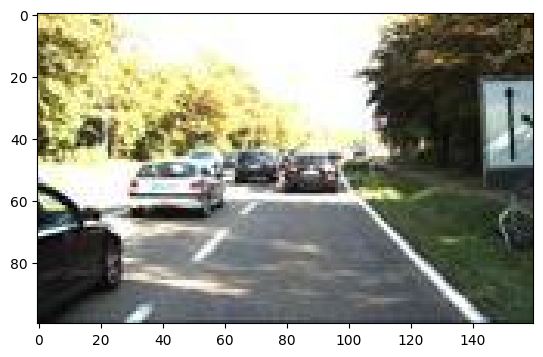

In [ ]:
import numpy as np

image = np.asarray(Image.open('./image-2.jpg'))
print(image.shape)
plot_one_image(image)

In [ ]:
new_image = image.copy()
print(new_image.shape)

(100, 160, 3)


Label: 


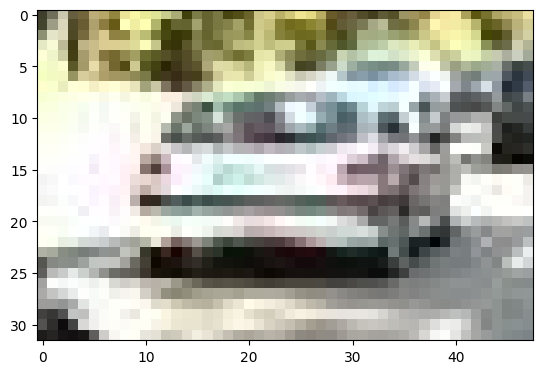

In [ ]:
x = 20
y = 40
window_h = 32
window_w = 48

plot_one_image(new_image[y:y+window_h, x:x+window_w])

In [ ]:
step_h = 16
step_w = 16
window_h = 32
window_w = 32
windows = []
windows = []
for y in range(0, new_image.shape[0], step_h):
  for x in range(0, new_image.shape[1], step_w):
    window = new_image[y:y+window_h, x:x+window_w]
    if window.shape[0]==window_h and window.shape[1]==window_w:
      windows.append(window)

In [ ]:
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0])

Label: [0]


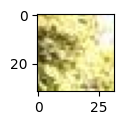

Label: [0]


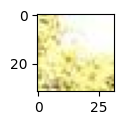

Label: [0]


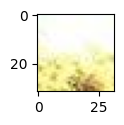

Label: [0]


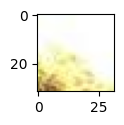

Label: [0]


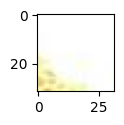

Label: [0]


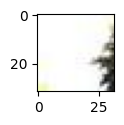

Label: [0]


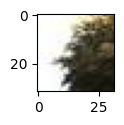

Label: [0]


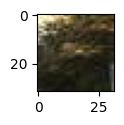

Label: [0]


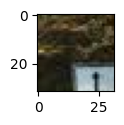

Label: [0]


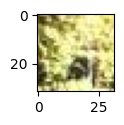

Label: [0]


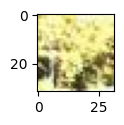

Label: [0]


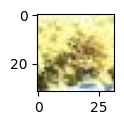

Label: [0]


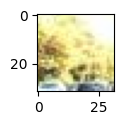

Label: [0]


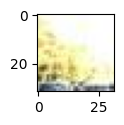

Label: [0]


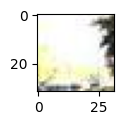

Label: [0]


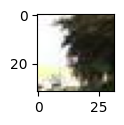

Label: [0]


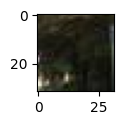

Label: [0]


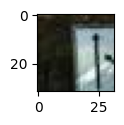

Label: [0]


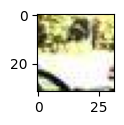

Label: [1]


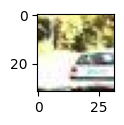

Label: [1]


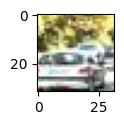

Label: [1]


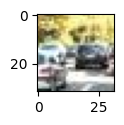

Label: [1]


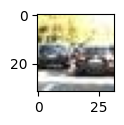

Label: [1]


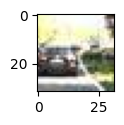

Label: [0]


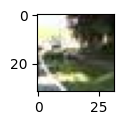

Label: [0]


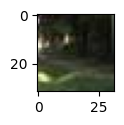

Label: [0]


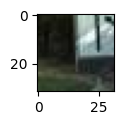

Label: [1]


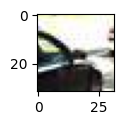

Label: [1]


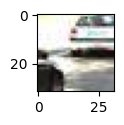

Label: [1]


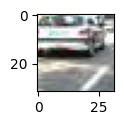

Label: [1]


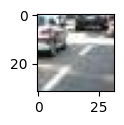

Label: [1]


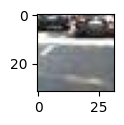

Label: [1]


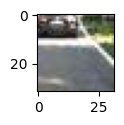

Label: [0]


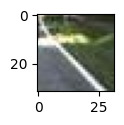

Label: [0]


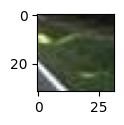

Label: [0]


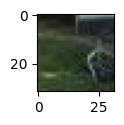

Label: [1]


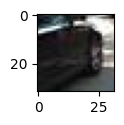

Label: [0]


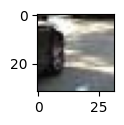

Label: [0]


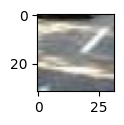

Label: [0]


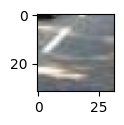

Label: [0]


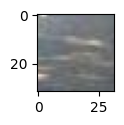

Label: [0]


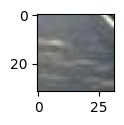

Label: [0]


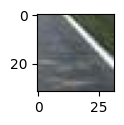

Label: [0]


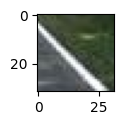

Label: [0]


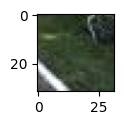

In [ ]:
for window, label in zip(windows, labels):
  plot_one_image(window, [label], fig_size=(1, 1))

In [ ]:
import numpy as np

windows = np.stack(windows)

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:

(X_train, y_train), (X_test, y_test) = load_vehicle_dataset()

In [ ]:

perceptron = Sequential()
perceptron.add(Flatten(input_shape = (32, 32, 3)))
perceptron.add(Dense(units = 128, activation = 'relu'))
perceptron.add(Dense(units = 3, activation = 'softmax'))

perceptron.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),
                   metrics=['accuracy'])

Epoch 1/20
469/469 [==============================] - 5s 9ms/step - loss: 0.8702 - accuracy: 0.6335 - val_loss: 0.7646 - val_accuracy: 0.6687
Epoch 2/20
 20/469 [>.............................] - ETA: 2s - loss: 0.6605 - accuracy: 0.7281

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 4s 8ms/step - loss: 0.6683 - accuracy: 0.7214 - val_loss: 0.7170 - val_accuracy: 0.6940
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.6078 - accuracy: 0.7560 - val_loss: 0.6982 - val_accuracy: 0.7157
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.5536 - accuracy: 0.7813 - val_loss: 0.6915 - val_accuracy: 0.7030
Epoch 5/20
469/469 [==============================] - 5s 11ms/step - loss: 0.5116 - accuracy: 0.7983 - val_loss: 0.6715 - val_accuracy: 0.7210
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.4761 - accuracy: 0.8114 - val_loss: 0.6791 - val_accuracy: 0.7243
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.4373 - accuracy: 0.8364 - val_loss: 0.6921 - val_accuracy: 0.7250
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 0.4081 - accuracy: 0.8450 - val_loss: 0.7196 - val_accuracy: 0.7180
Epoch 9/20
469/4

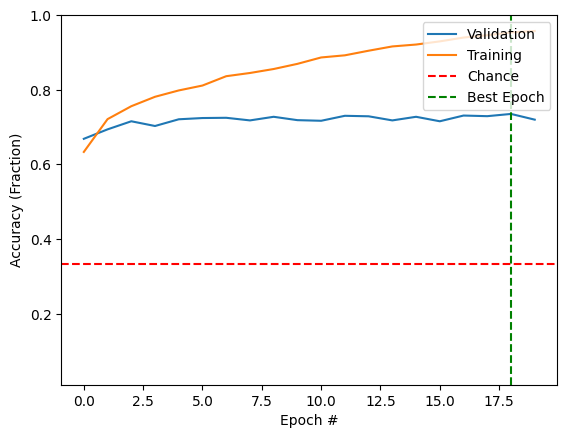

In [ ]:
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

y_train_onehot = label_to_onehot(y_train)
y_test_onehot = label_to_onehot(y_test)

history = perceptron.fit(X_train_norm, y_train_onehot, epochs=20, validation_data=(X_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])

plot_acc(history)

In [ ]:
### YOUR CODE HERE
windows_norm = normalize(windows)
output = perceptron.predict(windows_norm)

y_pred = np.argmax(output, axis=-1)
pred_prob = np.max(output, axis=-1)
### END CODE

2/2 [==============================] - 0s 29ms/step


Label: ['1 0.6338621']


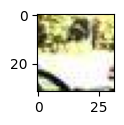

Label: ['1 0.9999807']


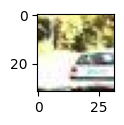

Label: ['1 0.7169037']


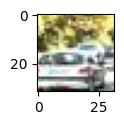

Label: ['2 0.99450547']


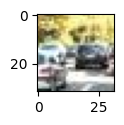

Label: ['2 0.6361778']


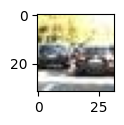

Label: ['1 0.78827786']


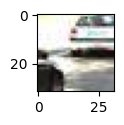

Label: ['1 0.99861526']


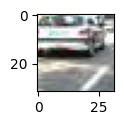

Label: ['2 0.9066606']


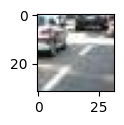

Label: ['1 0.813949']


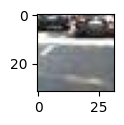

Label: ['1 0.9989147']


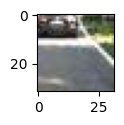

Label: ['2 0.75587946']


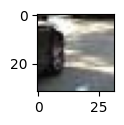

Label: ['1 0.6218017']


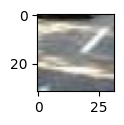

Label: ['1 0.6321747']


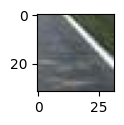

In [ ]:
threshold = 0.6

num_windows = windows.shape[0]
for i in range(num_windows):
  if y_pred[i]>0 and pred_prob[i]>threshold:
    plot_one_image(windows[i], labels=[" ".join([str(y_pred[i]), str(pred_prob[i])])], fig_size=(1,1))

In [ ]:
np.mean(y_pred == labels)

0.8

In [ ]:
def sliding_predictions(model, windows, threshold=0.6, labels=labels):
  windows_norm = normalize(windows)
  output = model.predict(windows_norm)

  y_pred = np.argmax(output, axis=-1)
  pred_prob = np.max(output, axis=-1)

  num_windows = windows.shape[0]
  for i in range(num_windows):
    if y_pred[i]>0 and pred_prob[i]>threshold:
      plot_one_image(windows[i], labels=[" ".join([str(y_pred[i]), str(pred_prob[i])])], fig_size=(1,1))

  return np.mean(y_pred == labels)

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 3, activation = 'softmax'))



Epoch 1/20
469/469 [==============================] - 4s 5ms/step - loss: 0.7671 - accuracy: 0.6665 - val_loss: 0.6507 - val_accuracy: 0.7197
Epoch 2/20
 28/469 [>.............................] - ETA: 1s - loss: 0.6106 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 2s 4ms/step - loss: 0.5617 - accuracy: 0.7747 - val_loss: 0.5595 - val_accuracy: 0.7713
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4829 - accuracy: 0.8101 - val_loss: 0.5168 - val_accuracy: 0.7893
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.4282 - accuracy: 0.8361 - val_loss: 0.4823 - val_accuracy: 0.8040
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3804 - accuracy: 0.8556 - val_loss: 0.4318 - val_accuracy: 0.8283
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.3310 - accuracy: 0.8743 - val_loss: 0.4590 - val_accuracy: 0.8210
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.2963 - accuracy: 0.8907 - val_loss: 0.4257 - val_accuracy: 0.8300
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 0.2554 - accuracy: 0.9079 - val_loss: 0.3992 - val_accuracy: 0.8433
Epoch 9/20
469/46

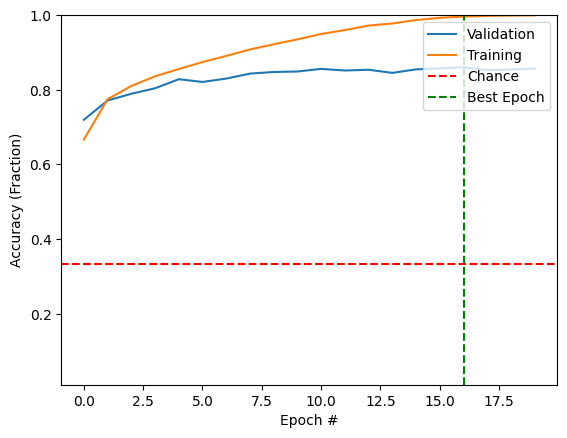

In [ ]:
### YOUR CODE HERE
cnn.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(learning_rate = 1e-3, momentum = 0.9),
            metrics = ['accuracy'])

cnn.fit(X_train_norm, y_train_onehot, epochs = 20, validation_data = (X_test_norm, y_test_onehot), shuffle = True, callbacks = [monitor])
### END CODE

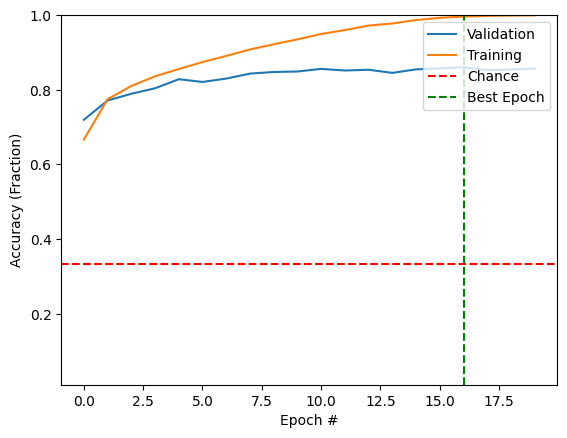

In [ ]:
plot_acc(cnn.history)

2/2 [==============================] - 0s 54ms/step
Label: ['2 0.98037076']


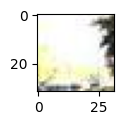

Label: ['1 0.9999355']


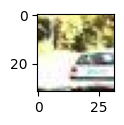

Label: ['1 0.999821']


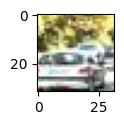

Label: ['2 0.99986684']


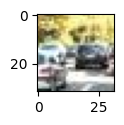

Label: ['2 0.99813807']


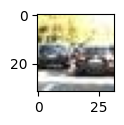

Label: ['1 0.9946444']


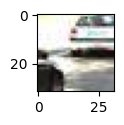

Label: ['1 0.9990381']


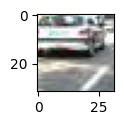

Label: ['1 0.99848396']


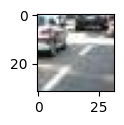

Label: ['1 0.9981445']


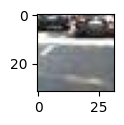

Label: ['1 0.99999833']


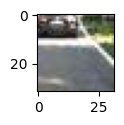

Label: ['1 0.9277585']


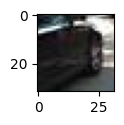

The accuracy is 0.7777777777777778


In [ ]:
### YOUR CODE HERE
acc = sliding_predictions(cnn, windows, threshold=0.9)
print("The accuracy is {}".format(acc))
### END CODE

Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 0.4150 - accuracy: 0.8397

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 21s 35ms/step - loss: 0.4150 - accuracy: 0.8397 - val_loss: 0.2373 - val_accuracy: 0.9147
Epoch 2/20
469/469 [==============================] - 15s 31ms/step - loss: 0.1948 - accuracy: 0.9329 - val_loss: 0.1811 - val_accuracy: 0.9357
Epoch 3/20
469/469 [==============================] - 14s 29ms/step - loss: 0.1404 - accuracy: 0.9533 - val_loss: 0.1921 - val_accuracy: 0.9293
Epoch 4/20
469/469 [==============================] - 14s 29ms/step - loss: 0.0906 - accuracy: 0.9692 - val_loss: 0.1989 - val_accuracy: 0.9323
Epoch 5/20
469/469 [==============================] - 14s 29ms/step - loss: 0.0716 - accuracy: 0.9755 - val_loss: 0.2963 - val_accuracy: 0.9107
Epoch 6/20
469/469 [==============================] - 14s 29ms/step - loss: 0.0447 - accuracy: 0.9851 - val_loss: 0.2182 - val_accuracy: 0.9413
Epoch 7/20
469/469 [==============================] - 14s 31ms/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.2165 - val_accuracy: 0.9433
Epo

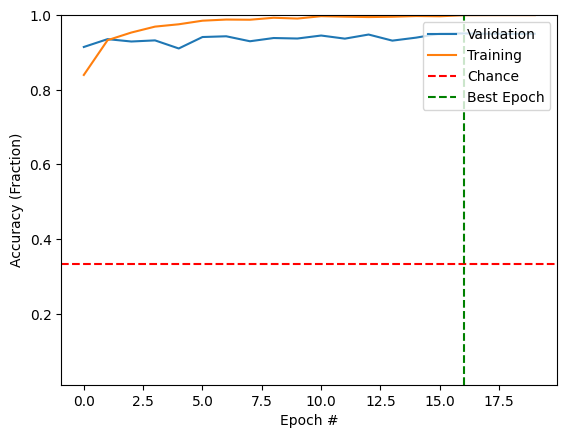

In [ ]:
transfer = TransferClassifier(name = 'VGG16')
transfer.fit(X_train_norm, y_train_onehot, epochs = 20, validation_data = (X_test_norm, y_test_onehot), shuffle = True, callbacks = [monitor])
plot_acc(transfer.history)

In [ ]:
# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model = Sequential()
vgg_model.add(vgg_expert)